<H1> Introdução </H1>
<p> 
    Os dados analisados aqui estão disponíveis no site do Instituto Nacional de Metereologia (INMET) em formato CSV e podem ser baixados através <a href="https://portal.inmet.gov.br/dadoshistoricos"> deste link </a> e por isso não foram incluídos no repositório. 
</p>

<p> 
    Os dados foram mantidos na organização original, com as tabelas divididas em pastas por ano e em arquivos segundo o local de medição. 
</p>

<p> Uma lista de todos os arquivos disponíveis foi salva no arquivo <i> files.txt </i> para facilitar a consulta dos mesmos e para permitir a quem esteja acessando este repositório consultar rapidamente quais arquivos estão disponíveis sem necessidade de baixá-los no site do INMET. </p>

<p> 
Os dados de 2024 não foram incluídos pois no momento em que este repositório foi criado o ano ainda não tinha acabado. Estes dados serão incluídos em algum momento no futuro. 
</p>

In [443]:
# Bibliotecas utilizadas
from datetime import datetime
from collections import Counter
import json
import geopandas
import pyogrio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<h1> Sobre os dados</h1>
<p> Cada arquivo CSV contém dados recolhidos a cada hora em um único local de medição durante um período máximo de um ano.</p>
<p> O período observado em cada arquivo sempre segue o ano civil. Deste modo, não há dados de dois anos diferentes em um mesmo arquivo. </p>
<p> O nome dos arquivos é padronizado no formato <i>INMET_SiglaRegiao_SiglaEstado_Codigo_Local_DataInicial_A_DataFinal.csv </i> (em letras maiúsculas), que é fácil de ser lido e que descreve os metadados dos mesmos, possibilitando uma rápida recuperação das informações desejadas. </p>
<p> <b>Observações:</b> <br> 
    1. Algumas poucas cidades possuem mais de um local de medição, mas por simplicidade será utilizado apenas o termo 'Cidade' para se referir aos locais nas tabelas e gráficos a seguir. <br>
    2. Existem três arquivos de dados de medições no Pelotão Especial de Fronteira de Bonfim, em Roaraima, que não correspondem ao padrão mencionado acima. 
</p>

In [178]:
# Lê a lista de arquivos e criar um dataframe com os dados. 
file = open("files.txt", "r")
file_content = file.read()
file_list = [x for x in file_content.splitlines() if len(x) > 2]

# O SEGUNDO REPLACE É PARA CORRIGIR O PROBLEMA DA OBSERVAÇÃO 2 ACIMA.
file_list_splitted = [ x.replace(".CSV","").replace("EB_PEF_BONFIM", "EB PEF BONFIM").strip().split('_')[0 : 8] + [x] for x in file_list]
df_files = pd.DataFrame(columns=["INMET", "REGIAO", "ESTADO", "CODIGO", "CIDADE", "DATA INI", "A", "DATA FIM", "ARQUIVO"],
                        data = file_list_splitted).drop(columns={"INMET", "A"})
# Mostra a tabela co
display(df_files)

,REGIAO,ESTADO,CODIGO,CIDADE,DATA INI,DATA FIM,ARQUIVO
0,CO,DF,A001,BRASILIA,07-05-2000,31-12-2000,INMET_CO_DF_A001_BRASILIA_07-05-2000_A_31-12-2...
1,NE,BA,A401,SALVADOR,13-05-2000,31-12-2000,INMET_NE_BA_A401_SALVADOR_13-05-2000_A_31-12-2...
2,N,AM,A101,MANAUS,09-05-2000,31-12-2000,INMET_N_AM_A101_MANAUS_09-05-2000_A_31-12-2000...
3,SE,RJ,A601,ECOLOGIA AGRICOLA,07-05-2000,31-12-2000,INMET_SE_RJ_A601_ECOLOGIA AGRICOLA_07-05-2000_...
4,S,RS,A801,PORTO ALEGRE,22-09-2000,31-12-2000,INMET_S_RS_A801_PORTO ALEGRE_22-09-2000_A_31-1...
...,...,...,...,...,...,...,...
8889,S,SC,A867,ARARANGUA,01-01-2023,31-12-2023,INMET_S_SC_A867_ARARANGUA_01-01-2023_A_31-12-2...
8890,S,SC,A868,ITAJAI,01-01-2023,31-12-2023,INMET_S_SC_A868_ITAJAI_01-01-2023_A_31-12-2023...
8891,S,SC,A870,RANCHO QUEIMADO,01-01-2023,31-12-2023,INMET_S_SC_A870_RANCHO QUEIMADO_01-01-2023_A_3...
8892,S,SC,A895,CHAPECO,01-01-2023,31-12-2023,INMET_S_SC_A895_CHAPECO_01-01-2023_A_31-12-202...


<h2>Dados sobre os locais de medição</h2>

In [179]:
print(f"Existem dados de {len(df_files['CIDADE'].unique())} locais diferentes")

Existem dados de 632 locais diferentes


In [180]:
composed_places = [y[0] for y in [x.split(' - ') for x in df_files[df_files['CIDADE'].str.contains(' - ')]['CIDADE'].unique()]] +\
                  [y[0] for y in [x.split(' (') for x in df_files[df_files['CIDADE'].str.contains('\(')]['CIDADE'].unique()]]

duplicated_cities = pd.concat([pd.Series(df_files[df_files['CIDADE'].isin(composed_places)]['CIDADE'].unique()),\
                               pd.Series([item for item, count in Counter(composed_places).items() if count > 1])]).to_list()
print("Cidades com mais de um local de medição: " + ', '.join(duplicated_cities))

Cidades com mais de um local de medição: SALVADOR, PORTO ALEGRE, CRISTALINA, NOVA FRIBURGO, SAQUAREMA, CAMPOS DOS GOYTACAZES, SAO PAULO, BELO HORIZONTE, RIO DE JANEIRO, BRASNORTE


In [181]:
# FUNCAO PARA DEFINIR AS CORES DA PRIMEIRA COLUNA EM TABELAS COM AGRUPAMENTO + REORDANAÇÂO DE DADOS
def color(x):
    no_repetitions = x.unique()
    return ["background-color: #f5f5f5; background: #f5f5f5" if np.where(no_repetitions == el)[0]%2 == 0 \
            else "background-color: #ffffff; background: #ffffff" for  index, el in x.items()]

In [287]:
# EXIBIÇÃO RESUMIDA DAS LOCALIDADES MONITORADAS POR REGIÃO E ESTADO. 
display(df_files[['REGIAO', 'ESTADO', 'CIDADE']]\
            .groupby(by=['REGIAO','ESTADO'])\
            .agg(['nunique', lambda col: ',  '.join([x.title() for x in col.sort_values().unique()])])\
            .sort_values(by=['REGIAO', ('CIDADE','<lambda_0>')], ascending=[True,False])\
            .rename(columns={ 'nunique': 'NÚMERO DE CIDADES', '<lambda_0>': 'CIDADES'}, level=1)\
            .droplevel(0, axis=1)\
            .style.set_properties(**{'text-align': 'left'}, subset='CIDADES')\
            .set_properties(**{'text-align': 'center'}, subset='NÚMERO DE CIDADES')\
            .apply_index(color, axis=0, level =[0]))\
            


In [459]:
df_area_estados = pd.read_csv("area_estados.csv", sep=";", decimal=',')
df_mapa = df_files[['ESTADO', 'CIDADE']]\
            .groupby(by='ESTADO')\
            .agg('nunique').merge(df_area_estados, on='ESTADO')\
            .assign(**{'AREA (KM2) POR CIDADE MONITORADA': lambda x : round(x.AREA/x.CIDADE, 1)})\
            .sort_values(by= 'AREA (KM2) POR CIDADE MONITORADA', ascending=False).reset_index(drop=True)
display(df_mapa)

,ESTADO,CIDADE,AREA,AREA (KM2) POR CIDADE MONITORADA
0,RR,3,223644.527,74548.2
1,AM,26,1559167.889,59968.0
2,AP,4,142470.762,35617.7
3,PA,35,1245870.798,35596.3
4,RO,7,237765.240,33966.5
5,AC,7,164123.964,23446.3
6,MT,40,903207.019,22580.2
7,MA,18,329642.182,18313.5
8,TO,20,277466.763,13873.3
9,GO,26,340203.329,13084.7


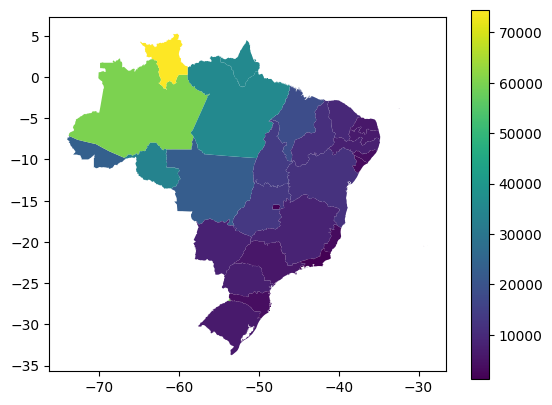

In [464]:
estados_geojson = geopandas.read_file('./geojson/brasil_estados.json')
estados_geojson['ESTADO'] = estados_geojson['id']
estados_geojson = estados_geojson.merge(df_mapa, on='ESTADO')

estados_geojson.plot(column='AREA (KM2) POR CIDADE MONITORADA', legend=True);

<H2> Histórico das medições </H2>
<p> Nesta seção podemos ver a evolução do número de estações durante todo o período de monitoramento e quais cidades/locais começaram a ser monitoradas em cada ano. </p>

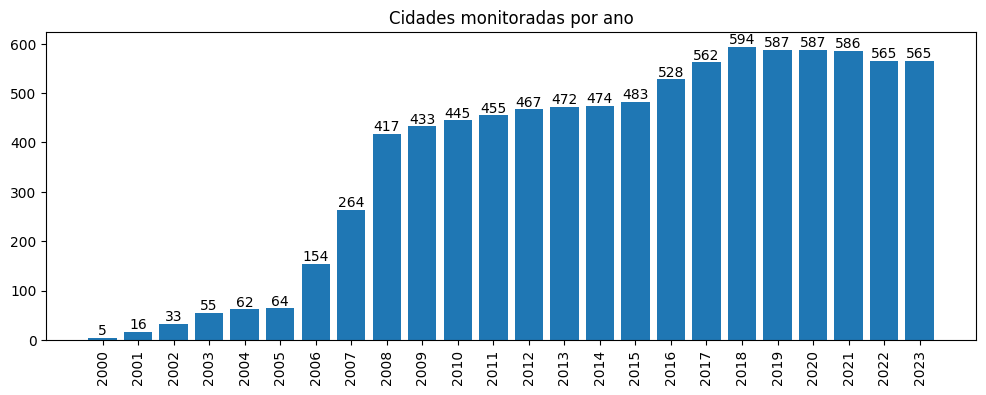

In [318]:
df_files['ANO'] = [x.split('-')[-1] for x in df_files['DATA INI']]
cities_by_year = df_files[['ANO', 'CIDADE']]\
            .groupby(by='ANO')\
            .agg({'CIDADE': ['nunique', lambda col: ',  '.join([x.title() for x in col.sort_values().unique()])]})\
            .rename(columns={ 'nunique': 'NÚMERO DE CIDADES', '<lambda_0>': 'CIDADES'}, level=1)\
            .droplevel(0, axis=1)

fig, ax = plt.subplots()
fig.set_size_inches(12, 4);
plt.xticks(rotation = 90)
ax.set_title('Cidades monitoradas por ano')
ax.bar(cities_by_year.index, cities_by_year['NÚMERO DE CIDADES']);
ax.bar_label(ax.containers[-1]);


<p> Pelo gráfico acima podemos ver que houve um salto no número de locais monitorados entre 2005 e 2008 e depois entre 2015 e 2018. <p>

In [288]:
# EXTRAI O ANO INICIAL E FINAL DE MONITORAMENTO EM CADA CIDADE (last, first) E DEPOIS AGRUPA POR ANO DE INICIO
# A PENÚLTIMA LINHA É INSERIDA PARA EXPANDIR A TABELA
display(df_files[['ANO', 'CIDADE']].groupby(['CIDADE']).agg({'last', 'first'})\
        .rename(columns={'first': 'ANO INICIO', 'last': 'ANO FIM'})\
        .droplevel(0, axis = 1).reset_index()[['CIDADE', 'ANO INICIO']]\
        .groupby(by='ANO INICIO').agg({'CIDADE':  lambda col: ',  '.join([x.title() for x in col.sort_values().unique()])   })\
        .style.set_properties(**{'text-align': 'left'})
        .apply_index(color, axis=0, level =[0]))

,CIDADE
ANO INICIO,
2000,"Brasilia, Ecologia Agricola, Manaus, Porto Alegre, Salvador"
2001,"Barreiras, Bauru, Campo Grande, Goiania, Morrinhos, Ponta Pora, Rio Grande, Santa Maria, Santana Do Livramento, Santo Augusto, Tres Lagoas"
2002,"Almenara, Araxa, Barbacena, Cambuci, Campo Novo Dos Parecis, Campos Do Jordao, Caravelas, Cuiaba, Franca, Guaranta Do Norte, Luiz Eduardo Magalhaes, Marambaia, Montes Claros, Sorriso, Tangara Da Serra, Uberlandia, Xerem"
2003,"Aracaju, Arq.Sao Pedro E Sao Paulo, Belem, Castanhal, Cruz Das Almas, Curitiba, Florianopolis, Fortaleza, Ilheus, Itaberaba, Itirucu, Ivinhema, Macajuba, Maceio, Natal, Parnaiba, Petrolina, Presidente Prudente, Rondonopolis, S.J. Do Rio Claro, Sao Luis, Sobral"
2004,"Arco Verde, Areia, Floriano, Monte Verde, Palmas, Recife, Teresina"
2005,"Parana, Vicosa"
2006,"Agua Boa, Alegre, Alegrete, Alfredo Chaves, Apiacas, Aquidauana, Arraial Do Cabo, Avare, Bento Goncalves, Cacapava Do Sul, Caldas, Camaqua, Campina Grande, Campina Verde, Campo Verde, Campos, Castro, Chapadao Do Sul, Comodoro, Conceicao Das Alagoas, Corumba, Coxim, Curvelo, Dourados, Erechim, Formiga, Gurupi, Icaraima, Iguape, Inacio Martins, Indaial, Itapeva, Ituiutaba, Ivai, Joaquim Tavora, Juara, Juina, Linhares, Lins, Luziania, Macae, Mal. Candido Rondon, Maracaju, Maria Da Fe, Maringa, Miranda, Muriae, Nhumirim, Nova Tebas, Ourinhos, Ouro Branco, Pampulha, Paranaiba, Paranatinga, Parati, Passo Fundo, Passos, Patrocinio, Peixe, Pico Do Couto, Piracicaba, Porto Murtinho, Rancharia, Resende, Rio Pardo, Sacramento, Santa Rosa, Sao Carlos, Sao Gabriel Do Oeste, Sao Joao Del Rei, Sao Jose Dos Ausentes, Sao Mateus, Sao Miguel Arcanjo, Sao Paulo - Mirante, Sao Simao, Serra Dos Aimores, Sinop, Sorocaba, Taubate, Teofilo Otoni, Teresopolis, Timoteo, Torres, Tres Marias, Uruguaiana, Valenca, Varginha, Vila Bela Da Santissima Trindade, Vitoria, Votuporanga"
2007,"Aguas Vermelhas, Aimores, Alta Floresta, Alto Paraiso De Goias, Alvorada Do Gurgueia, Apodi, Aragarcas, Araguaina, Ariranha, Bage, Balsas, Barbalha, Bom Jardim Da Serra - Morro Da Igreja, Bom Jesus Da Lapa, Bom Jesus Do Piaui, Buritis, Cabrobo, Caiaponia, Caico, Cangucu, Capelinha, Caracol, Caratinga, Carolina, Caruaru, Casa Branca, Chapada Gaucha, Correntina, Cotriguacu, Cristalina, Cruz Alta, Diamantina, Dois Vizinhos, Dores Do Indaia, Esperantina, Espinosa, Feira De Santana, Forte De Copacabana, Frederico Westphalen, Garanhuns, Goianesia, Goias, Governador Valadares, Guanhaes, Guaramiranga, Guarda-Mor, Ibitinga, Iguatu, Ilha Do Mel, Itabaianinha, Itaobim, Itapaci, Itapira, Itapoa, Itumbiara, Jaguarao, Jaguaruana, Jales, Jatai, Joacaba, Joao Pessoa, Joao Pinheiro, Jose Bonifacio, Juiz De Fora, Lagoa Vermelha, Macau, Mantena, Mineiros, Mocambinho, Montalvania, Monte Alegre De Goias, Monteiro, Morada Nova, Mossoro, Nova Fatima, Palmeira Dos Indios, Pao De Acucar, Paragominas, Passa Quatro, Patos, Paulistana, Pedro Afonso, Pirapora, Pires Do Rio, Piripiri, Planalto, Porto Velho, Posse, Quarai, Querencia, Quixeramobim, Rio Pardo De Minas, Rio Verde, Salinas, Santa Rita De Cassia, Santa Teresa, Sao Borja, Sao Felix Do Araguaia, Sao Gabriel, Sao Goncalo, Sao Joao Do Piaui, Sao Luis Do Paraitinga, Sao Luiz Gonzaga, Sao Romao, Taua, Tome Acu, Unai, Valparaiso, Vila Militar, Vitoria Da Conquista"
2008,"Abrolhos, Aguas Emendadas, Alto Parnaiba, Alto Taquari, Amambai, Amargosa, Apui, Arapiraca, Ararangua, Ariquemes, Autazes, Bacabal, Barcelos, Barra, Barra Bonita, Barra Do Corda, Barra Do Turvo, Boca Do Acre, Braganca, Brasnorte (Mundo Novo), Brejo Grande, Brumado, Buriticupu, Buritirama, Cabaceiras, Cacador, Cacoal, Calcanhar, Camaratuba, Cameta, Campos Sales, Canela, Carira, Carlinda, Cassilandia, Catalao, Caxias, Chapadinha, Cidade Gaucha, Clevelandia, Coari, Colinas, Conceicao Do Araguaia, Conde, Coruripe, Crateus, Curitibanos, Delfino, Diamante Do Norte, Dianopolis, Dionisio Cerqueira, Estreito, Euclides Da Cunha, Farol De Santana, Floresta, Florestal, Formoso Do A

<h3> Monitoramentos descontinuados </h3> 
<p> Na tabela abaixo listamos os locais que tiveram o monitoramento descontinuado antes dos ano de 2003. Alguns desses eram monitorados há cerca de 20 anos. </p> 

In [275]:
df_files[['ANO', 'CIDADE']].groupby(['CIDADE']).agg({'first', 'last'}).droplevel(0, axis = 1)\
        .query("last < '2023'").reset_index()\
        .rename(columns={'first': 'ANO INICIO', 'last': 'ANO FIM'}).groupby(by=['ANO INICIO', 'ANO FIM'])\
        .agg({'CIDADE' :lambda col: ',  '.join([x.title() for x in col.sort_values()])})\
        .style.set_properties(**{'text-align': 'left'})\
        .apply_index(color, axis=0, level =[0])

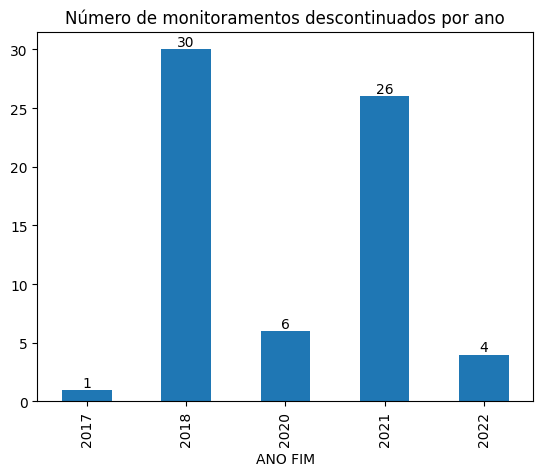

In [315]:
ax = df_files[['ANO', 'CIDADE']].groupby(['CIDADE']).agg({'last'}).droplevel(0, axis = 1)\
        .query("last < '2023'").reset_index()[['CIDADE', 'last']]\
        .rename(columns={ 'last': 'ANO FIM'}).groupby(by=['ANO FIM']).count()\
        .plot(kind='bar', title='Número de monitoramentos descontinuados por ano');
ax.bar_label(ax.containers[0]);
ax.legend().remove();